In [26]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import stft
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os
import pandas as pd
from tqdm import tqdm

In [12]:
DATASET_PATH = "/kaggle/input/urbansound8k"
CSV_FILE = os.path.join(DATASET_PATH, "UrbanSound8K.csv")

In [13]:
data = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# **Hyperparameters**

In [22]:
N_FFT = 1024
HOP_LENGTH = 512
BATCH_SIZE = 64
num_samples = len(data)
WINDOW_SIZES = ['hann', 'hamming', 'boxcar']

# Utility Functions


In [15]:
def load_metadata(csv_file):
    return pd.read_csv(csv_file)

def load_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

In [16]:
def get_window_numpy(window_type, n_fft):
    if window_type == 'hann':
        return np.hanning(n_fft)
    elif window_type == 'hamming':
        return np.hamming(n_fft)
    elif window_type == 'boxcar':  # Equivalent to a rectangular window
        return np.ones(n_fft)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

In [17]:
def plot_spectrogram(audio, sr, window_type):
    window = get_window_numpy(window_type, N_FFT)
    f, t, Zxx = stft(audio, fs=sr, window=window, nperseg=N_FFT, noverlap=HOP_LENGTH)

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title(f"Spectrogram with {window_type.capitalize()} Window")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()

In [18]:
def extract_features(audio, sr, window_type):
    window = get_window_numpy(window_type, N_FFT)
    f, t, Zxx = stft(audio, fs=sr, window=window, nperseg=N_FFT, noverlap=HOP_LENGTH)
    return np.mean(np.abs(Zxx), axis=1)  

In [19]:
def load_sample_data(base_path, metadata, window_type, num_samples=100):
    features = []
    labels = []
    sample_count = 0

    for start_idx in tqdm(range(0, num_samples, BATCH_SIZE), desc="Loading and Processing Audio Batches"):
        end_idx = min(start_idx + BATCH_SIZE, num_samples)

        for index in range(start_idx, end_idx):
            if index >= len(metadata):
                break

            row = metadata.iloc[index]
            file_name = row['slice_file_name']
            fold = row['fold']
            class_label = row['class']
            file_path = os.path.join(base_path, f"fold{int(fold)}", file_name)

            if not os.path.exists(file_path):
                continue

            audio, sr = load_audio(file_path)
            feature = extract_features(audio, sr, window_type)
            features.append(feature)
            labels.append(class_label)

            sample_count += 1

    return np.array(features), np.array(labels)

In [29]:
def train_svc_model(window_type):
    metadata = load_metadata(CSV_FILE)
    X, y = load_sample_data(DATASET_PATH, metadata, window_type, num_samples)

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = SVC(kernel='linear')
    clf.fit(X_train_scaled, y_train)
    
    # Evaluate the classifier
    y_pred = clf.predict(X_test_scaled)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Spectogram Visualization for Sample Audio

In [36]:
audio, sr = load_audio('/kaggle/input/urbansound8k/fold8/106905-5-0-1.wav', sr = 5000)

Spectrogram Visualizations:


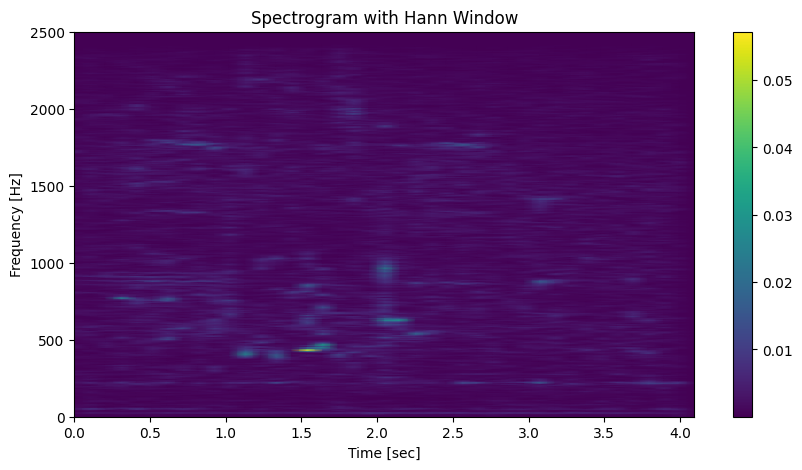

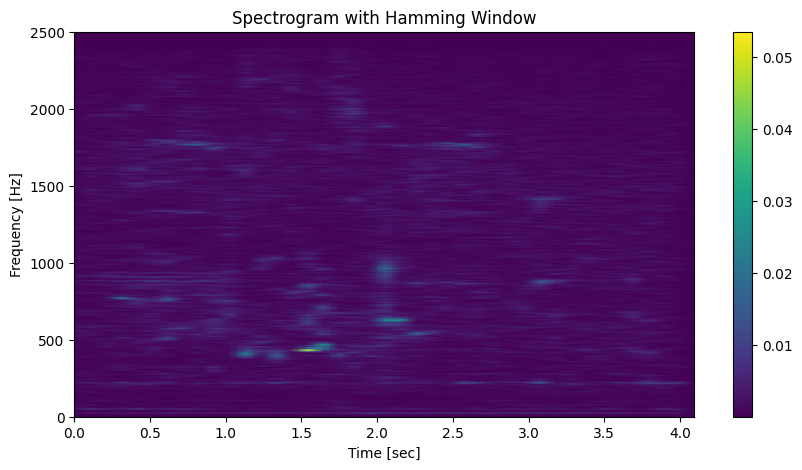

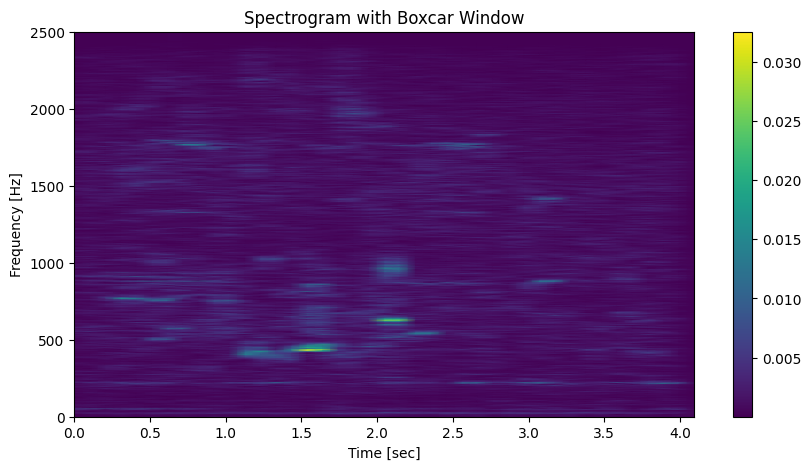

In [37]:
print("Spectrogram Visualizations:")
for window_type in WINDOW_SIZES:
    plot_spectrogram(audio, sr, window_type)

# Training and Comparison

In [38]:
train_svc_model('hann')

Loading and Processing Audio Batches: 100%|██████████| 137/137 [02:27<00:00,  1.07s/it]


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.75      0.74      0.75       203
        car_horn       0.79      0.72      0.76        86
children_playing       0.42      0.75      0.54       183
        dog_bark       0.64      0.58      0.61       201
        drilling       0.76      0.70      0.73       206
   engine_idling       0.85      0.84      0.85       193
        gun_shot       0.67      0.43      0.53        72
      jackhammer       0.88      0.80      0.84       208
           siren       0.76      0.72      0.74       165
    street_music       0.75      0.61      0.67       230

        accuracy                           0.70      1747
       macro avg       0.73      0.69      0.70      1747
    weighted avg       0.73      0.70      0.71      1747



In [39]:
train_svc_model('hamming')

Loading and Processing Audio Batches: 100%|██████████| 137/137 [02:07<00:00,  1.08it/s]


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.75      0.75      0.75       203
        car_horn       0.82      0.74      0.78        86
children_playing       0.42      0.77      0.55       183
        dog_bark       0.63      0.56      0.59       201
        drilling       0.77      0.70      0.73       206
   engine_idling       0.85      0.84      0.85       193
        gun_shot       0.73      0.44      0.55        72
      jackhammer       0.87      0.79      0.83       208
           siren       0.78      0.70      0.74       165
    street_music       0.77      0.64      0.70       230

        accuracy                           0.71      1747
       macro avg       0.74      0.70      0.71      1747
    weighted avg       0.74      0.71      0.71      1747



In [40]:
train_svc_model('boxcar')

Loading and Processing Audio Batches: 100%|██████████| 137/137 [02:08<00:00,  1.07it/s]


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.74      0.74      0.74       203
        car_horn       0.83      0.69      0.75        86
children_playing       0.43      0.75      0.55       183
        dog_bark       0.61      0.56      0.59       201
        drilling       0.77      0.73      0.75       206
   engine_idling       0.86      0.83      0.85       193
        gun_shot       0.72      0.50      0.59        72
      jackhammer       0.88      0.80      0.84       208
           siren       0.78      0.75      0.76       165
    street_music       0.76      0.62      0.69       230

        accuracy                           0.71      1747
       macro avg       0.74      0.70      0.71      1747
    weighted avg       0.74      0.71      0.72      1747

